In [88]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import trueskill.trueskill as ts 
%matplotlib inline

In [89]:
# Initialize TrueSkill module
# From http://trueskill.org
ts.backends.choose_backend('scipy')
ts.setup(draw_probability=0.01)
ts.Rating()

trueskill.trueskill.Rating(mu=25.000, sigma=8.333)

In [90]:
def create_player_skills(mu, sigma, n):
    return np.random.normal(mu, sigma, n)

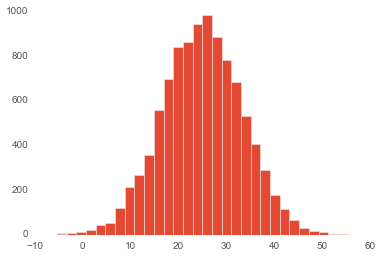

In [91]:
# Distribution of player skill
_ = plt.hist(create_player_skills(25, 25/3, 10000), bins=30)

In [92]:
# half of one std deviation (i.e. 25/6) in difference between players equals ~80% win chance  
player_uneveness = 25/6 

In [93]:
def create_initial_player_ratings(n):
    return np.array([ts.Rating() for x in range(n)])

In [94]:
def simulate_round_with_teams(team1, team2, player_skills, ratings):
    
    # Simple simulation of game round between team 1 and team 2
    t1_skill_sum = (player_skills[team1] + np.random.normal(0, player_uneveness, len(team1))).sum()
    t2_skill_sum = (player_skills[team2] + np.random.normal(0, player_uneveness, len(team2))).sum()
    
    t1_skill_sum += random.uniform(-t1_skill_sum/2, t1_skill_sum/2) # Not playing the objective
    outcome = 0
    if t1_skill_sum > t2_skill_sum:
        outcome = 1
    if t1_skill_sum < t2_skill_sum:
        outcome = 2
    return outcome

In [95]:
def simulate_round(n_players, team_size, player_skills, ratings, player_round_count):
    
    # Create to random teams
    subset = np.random.choice(n_players, size=team_size*2, replace=False)
    team1 = subset[0:team_size//2]
    team2 = subset[team_size//2:team_size]
    
    # Simulate a round between the teams
    player_round_count[team1] += 1
    player_round_count[team2] += 1
    outcome = simulate_round_with_teams(team1, team2, player_skills, ratings)

    # Calculate new ratings according to outcome
    r1 = ratings[team1].tolist()
    r2 = ratings[team2].tolist()
    if outcome == 1:
        new_ratings = ts.rate([r1, r2], [0, 1]) # team1 won
    elif outcome == 2: 
        new_ratings = ts.rate([r1, r2], [1, 0]) # team2 won
    else:
        new_ratings = ts.rate([r1, r2], [0, 0]) # draw
    
    # Update player ratings
    for (p, i) in zip(team1, range(len(team1))):
        ratings[p] = new_ratings[0][i]
    for (p, i) in zip(team2, range(len(team2))):
        ratings[p] = new_ratings[1][i]
    
    return ratings, player_round_count


In [96]:
def estimate_skills(ratings):
    return np.array([r.mu for r in ratings])

In [97]:
def simulate(team_size = 4, player_rounds = 20):
    
    # Init simulation params
    n_players = team_size * 500 
    rounds = (n_players // team_size) * player_rounds
    ratings = create_initial_player_ratings(n_players)
    player_skills = create_player_skills(25, 25/3, n_players)
    print('Team size: %d  Players: %d  Simulated global rounds: %d' % (team_size, n_players, rounds))
    print('Player')
    print('rounds\tRMSE\tSigma')
    
    # Init statistics
    player_round_count = np.zeros(n_players)
    rmses = []
    skill_sigmas = []
    current_round_count = -1
    
    for i in range(rounds):
  
        # Simulate a round
        ratings, player_round_count = simulate_round(n_players, team_size, player_skills, ratings, player_round_count)
        
        # Sample statistics whenever the mean round count of players change
        round_count_mean = int(player_round_count.mean())
        if current_round_count != round_count_mean:
            current_round_count = round_count_mean
            estimated_skills = estimate_skills(ratings) 
            skill_sd_mean = np.array([r.sigma for r in ratings]).mean()
            rmse = math.sqrt(((player_skills - estimated_skills) ** 2).mean())
            rmses.append(rmse)
            skill_sigmas.append(skill_sd_mean)
            if current_round_count % (player_rounds//10) == 0: # Show progress every 10th player round
                print("%d \t%1.2f \t%1.2f" % (round_count_mean, rmse, skill_sd_mean))
            
    print()
    return (player_skills, ratings, rmses, skill_sigmas) 

In [98]:
def plot_results(players_skills, ratings, rmses, skill_sigmas):
    estimated_skills = estimate_skills(ratings) 

    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(6)
    
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Rounds', fontsize=16)
    ax1.set_ylim([0,10])
    ax1.plot(rmses, label='$\sqrt{MSE}$')
    ax1.plot(skill_sigmas, label='$\sigma_{TrueSkill}$')
    ax1.legend(loc='upper right', fontsize=16)
    
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('Estimated skill after last round', fontsize=14)
    ax2.set_xlabel('Actual skill', fontsize=16)
    ax2.set_ylim(0,50)
    ax2.set_xlim(0,50)
    ax2.scatter(player_skills, estimated_skills, alpha=200/len(player_skills))
    ax2.plot([0,50],[0,50], color = '#666666')
    
    plt.show()

In [99]:
def plot_summary(final_rmses, final_skill_sigmas):
    
    fig = plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(8)
    
    ax1 = fig.add_subplot(121)
    ax1.grid(True)
    ax1.set_ylabel('$\sqrt{MSE}$', fontsize=20)
    ax1.set_xlabel('Rounds', fontsize=16)
    ax1.set_ylim([0,10])
    
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('$\sigma_{TrueSkill}$', fontsize=20)
    ax2.set_xlabel('Rounds', fontsize=16)
    ax2.grid(True)
    ax2.set_ylim([0,10])
    
    for team_size in sorted(final_rmses.keys()):
        ax1.plot(final_rmses[team_size], label=str(team_size))
    for team_size in sorted(final_skill_sigmas.keys()):
        ax2.plot(final_skill_sigmas[team_size], label=str(team_size)) 
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
      
    plt.show()

Simulating team sizes [2, 4, 8, 16, 32] with player uneveness = 4.17
Team size: 2  Players: 1000  Simulated global rounds: 80000
Player
rounds	RMSE	Sigma
0 	8.57 	8.33
16 	4.09 	2.76
32 	3.38 	1.88
48 	3.27 	1.52
64 	3.23 	1.32
80 	3.24 	1.19
96 	3.27 	1.11
112 	3.25 	1.05
128 	3.26 	1.01
144 	3.26 	0.98
160 	3.29 	0.95



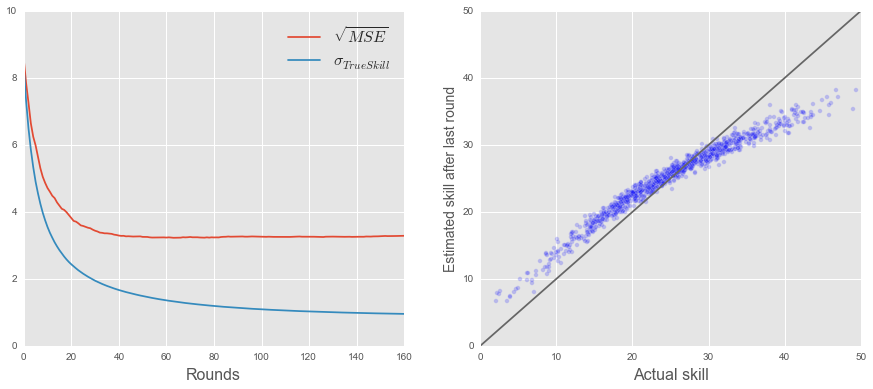

Team size: 4  Players: 2000  Simulated global rounds: 80000
Player
rounds	RMSE	Sigma
0 	8.61 	8.33
16 	5.61 	3.99
32 	4.69 	2.72
48 	4.39 	2.15
64 	4.24 	1.83
80 	4.19 	1.62
96 	4.15 	1.48
112 	4.15 	1.38


KeyboardInterrupt: 

In [100]:
# Run the simulation
final_rmses = {}
final_skill_sigmas = {}
plt.style.use('ggplot')
team_sizes = [2, 4, 8, 16, 32]

print('Simulating team sizes %r with player uneveness = %.2f' % (team_sizes, player_uneveness))

# Simulate different team sizes
for team_size in team_sizes:
    player_skills, ratings, rmses, skill_sigmas = simulate(team_size = team_size, player_rounds = 160)
    
    # Save simulation results for this team size
    final_rmses[team_size] = rmses
    final_skill_sigmas[team_size] = skill_sigmas
    
    # Plot results for this team size
    plot_results(player_skills, ratings, rmses, skill_sigmas)

# Summary plots containing all team sizes
plot_summary(final_rmses, final_skill_sigmas)
